### Results For paper

In [1]:
!aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_nofilter_g/ ../Final/Data/AE_nofilter_g/ --recursive

download: s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_nofilter_g/matched0.p to ../Final/Data/AE_nofilter_g/matched0.p
download: s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_nofilter_g/matched_controls_latent_from_algo.p to ../Final/Data/AE_nofilter_g/matched_controls_latent_from_algo.p
download: s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_nofilter_g/matched_controls_aggregate.p to ../Final/Data/AE_nofilter_g/matched_controls_aggregate.p
download: s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_nofilter_g/matched_controls_latent_after_process.p to ../Final/Data/AE_nofilter_g/matched_controls_latent_after_process.p
download: s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_nofilter_g/matched_controls_original.p to ../Final/Data/AE_nofilter_g/matched_controls_original.p
download: s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/AE_nofilter_g/controls_all.p to ../Final/Data/AE_nofilter_g/controls_all.p


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [3]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

#create paths if not created
from pathlib import Path

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [4]:
np.random.seed(seed = 0)

### Load Data

In [5]:
%%time
folder_name = "AE_nofilter_g/"
p = '../Final/Data/' + folder_name
p1 = '../Pre_Matching_DATA/'

base_path = '../Final/results/' + folder_name
Path(base_path).mkdir(exist_ok=True)

treated = pd.read_pickle(p1+'treated2Past2.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'matched_controls_original.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 251 ms, sys: 162 ms, total: 413 ms
Wall time: 431 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [6]:
treated.MYR.min()

201710

In [7]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 202001
    month_filter_upper = 202101
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [8]:
filter_cols =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 0

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [9]:

path_tabs = base_path+'tables/survival/'
path_figs = base_path+'figures/kaplan/'
path_figs2 = base_path+'figures/cox/' #plots without risk at count

p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [10]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E', 'Treatment']

summary_names = ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness', 'Treatment']

### Diabetes

In [11]:
%%time
after = 0
grace = 0 # if grace is setted after is setted 0 by default
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survTr = survTr[~((survTr['T'] <=2) & (survTr['E'] == 1))].reset_index(drop = True)
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])

CPU times: user 12 s, sys: 35.9 ms, total: 12 s
Wall time: 12 s


In [12]:
survTr.head()

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  ALLOW_AMT  \
0  2602482  24  0      0     0.0     0.0        0               81          0   
1  2603072  19  0      0     0.0     0.0        1               82        101   
2  2606370  10  0      0     0.0     0.0        1               82         23   
3  2621187  19  0      0     0.0     0.0        2               78      13007   
4  2623521  29  0      0     0.0     0.0        0               77          0   

   ALLOW_ER  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  MEDICAID_LOB  \
0       0.0  ...       0      0.0      0.0     0    1         0    Commercial   
1       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
2       0.0  ...       0      0.0      0.0     1    1         0      Medicare   
3       0.0  ...       0      0.0      0.0     0    1         1      Medicare   
4       0.0  ...       0      0.0      0.0     0    1         0      Medicare   

      MYR  PREGNANCY  Treatment  
0  201908        0.0          1  
1  202001        0.0          1  
2  202010        0.0          1  
3  202001        0.0          1  
4  201903        0.0          1  

[5 rows x 94 columns]

In [13]:
survTr.shape, survCo.shape

In [14]:
survTr.shape, survCo.shape

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


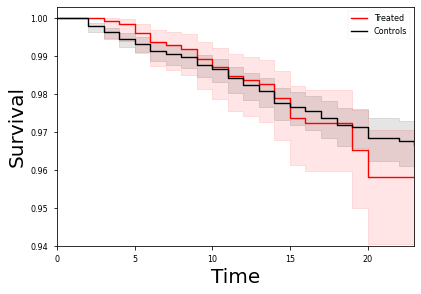

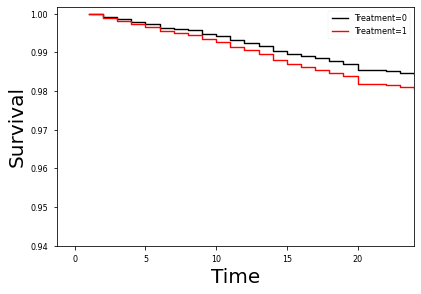

In [15]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
ylimDB = [0.94]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title, ylim = ylimDB)

In [16]:
lrsumm

test_statistic         p  -log2(p)
Diabetes        0.569045  0.450639  1.149957

In [17]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                               1.890           0.574        3.291    0.001
Total Cost                        0.088           0.032        2.757    0.006
Gender                            0.426           0.154        2.756    0.006
Tobacco Use                       0.388           0.225        1.721    0.085
Pressure                         -0.629           1.015       -0.619    0.536
Obesity                           0.740           0.161        4.583    0.000
Hypertension                      0.437           0.182        2.404    0.016
Hypothyroid                      -0.300           0.299       -1.005    0.315
Disease Count                    -0.216           0.734       -0.295    0.768
Acute Care 2 Months              -0.008           0.368       -0.022    0.982
Acute Care 6 Months               0.026           0.755        0.034    0.973
Inpatient Visits 6 Months        -0.001           0.676       -0.001    0.999
Emergency Vistits 6 Months       -0.076           0.724       -0.105    0.916
Line of Bussiness                -0.611           0.223       -2.743    0.006
Treatment                         0.224           0.194        1.157    0.247

### ER

data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [18]:
treated.columns

Index(['PERS_ID', 'MYR', 'MBR_GNDR', 'AGE_AT_MIDMONTH', 'ALLOW_AMT',
       'MEDICAID_LOB', 'ALLOW_ER', 'ALLOW_IP', 'CC_ADHD', 'CC_ALZHEIMER',
       'CC_ALZHEIMER_PLUS', 'CC_AMI', 'CC_ANEMIA', 'CC_ANXIETY_DISORDER',
       'CC_ARTHRITIS', 'CC_ASTHMA', 'CC_ATRIAL_FIB', 'CC_AUTISM', 'CC_BIPOLAR',
       'CC_BPH', 'CC_BREAST_CANCER', 'CC_CATARACT', 'CC_CEREBRAL_PALSY',
       'CC_CHRONIC_KIDNEY', 'CC_COLORECTAL_CANCER', 'CC_COPD',
       'CC_CYSTIC_FIBROSIS', 'CC_DEPRESSION', 'CC_DEPRESSIVE_DISORDERS',
       'CC_DEVELOP_DELAYS', 'CC_DIABETES', 'CC_DISAB_DX_CNT', 'CC_DX_CNT',
       'CC_ENDOMETRIAL_CANCER', 'CC_EPILEPSY', 'CC_FIBROMYALGIA',
       'CC_GLAUCOMA', 'CC_HEARING_IMPAIR', 'CC_HEART_FAILURE',
       'CC_HEPATITIS_A', 'CC_HEPATITIS_B_ACUTE', 'CC_HEPATITIS_B_CHRONIC',
       'CC_HEPATITIS_C_ACUTE', 'CC_HEPATITIS_C_CHRONIC',
       'CC_HEPATITIS_C_UNSPECIFIED', 'CC_HEPATITIS_D', 'CC_HEPATITIS_E',
       'CC_HEPATITIS_GEN', 'CC_HIP_FRACTURE', 'CC_HYPERLIPIDEMIA',
       'CC_HYPERTE

In [19]:
%%time
onset = 'ER_BIN'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, 
                                                 grace = grace, 
                                                 onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])

survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset,
                                                  grace = grace).reset_index(drop = True).dropna(axis = 0,subset = ['PERS_ID'])


CPU times: user 12.1 s, sys: 58.3 ms, total: 12.2 s
Wall time: 12.2 s


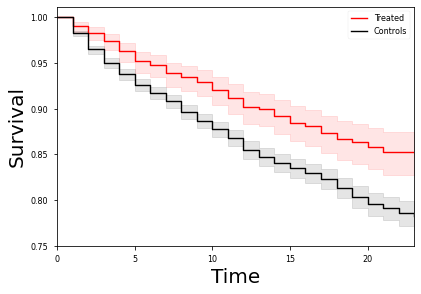

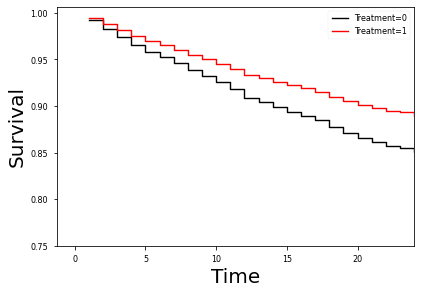

In [20]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
ylimER = [0.75]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, path_figs2=path_figs2, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimER)

In [21]:
lrsumm

test_statistic         p   -log2(p)
Emergency Visits       21.766761  0.000003  18.309162

In [22]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -1.222           0.205       -5.973    0.000
Total Cost                        0.037           0.012        3.122    0.002
Gender                           -0.049           0.063       -0.777    0.437
Tobacco Use                       0.176           0.084        2.108    0.035
Pressure                          0.609           0.286        2.127    0.033
Obesity                          -0.020           0.064       -0.315    0.753
Hypertension                      0.080           0.076        1.043    0.297
Hypothyroid                      -0.009           0.105       -0.082    0.935
Disease Count                     1.637           0.278        5.878    0.000
Acute Care 2 Months               1.404           0.106       13.306    0.000
Acute Care 6 Months               0.284           0.197        1.442    0.149
Inpatient Visits 6 Months        -0.621           0.153       -4.070    0.000
Emergency Vistits 6 Months        0.155           0.186        0.832    0.405
Line of Bussiness                -0.650           0.076       -8.542    0.000
Treatment                        -0.325           0.088       -3.694    0.000

### IP

data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [23]:
%%time
onset = 'IP_BIN'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 12 s, sys: 50.3 ms, total: 12.1 s
Wall time: 12.1 s


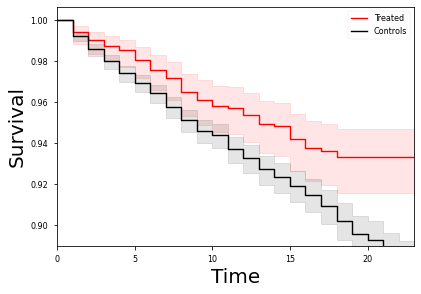

In [24]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
ylimIP =  [0.89]

lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimIP)

In [25]:
lrsumm

test_statistic         p   -log2(p)
Inpatient Visits       12.450362  0.000418  11.224517

In [26]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                               1.501           0.308        4.874    0.000
Total Cost                        0.097           0.019        5.200    0.000
Gender                            0.061           0.086        0.715    0.475
Tobacco Use                       0.033           0.125        0.268    0.789
Pressure                         -0.188           0.291       -0.646    0.518
Obesity                           0.037           0.088        0.424    0.672
Hypertension                      0.199           0.103        1.931    0.054
Hypothyroid                      -0.118           0.138       -0.856    0.392
Disease Count                     2.027           0.335        6.061    0.000
Acute Care 2 Months               1.065           0.149        7.153    0.000
Acute Care 6 Months               0.517           0.183        2.824    0.005
Inpatient Visits 6 Months         0.298           0.160        1.865    0.062
Emergency Vistits 6 Months       -0.664           0.160       -4.146    0.000
Line of Bussiness                -0.290           0.127       -2.294    0.022
Treatment                        -0.310           0.124       -2.499    0.012

### Acute Care IP OR ER

data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [27]:
# data = [treated,  controls]
# for d in data:
#     d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [28]:
%%time
onset = 'ACUTE'

survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 11.9 s, sys: 44.4 ms, total: 12 s
Wall time: 12 s


In [29]:
survTr[survTr.E >0]

PERS_ID   T  E  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  ALLOW_AMT  \
4     2619378   3  1     0.0     0.0        1               78        399   
5     2621187  11  1     0.0     0.0        2               78      13007   
6     2623521  28  1     0.0     0.0        0               77          0   
16    2651688   4  1     0.0     0.0        0               74        179   
26    2668219   5  1     0.0     0.0        0               71        346   
...       ...  .. ..     ...     ...      ...              ...        ...   
1330  4390059   4  1     0.0     0.0        0               47          2   
1334  4398341  11  1     0.0     0.0        0               66          0   
1337  5001236  16  1     0.0     0.0        0               60        374   
1342  5003200   1  1     1.0     1.0        1               55       3137   
1348  5014675   3  1     0.0     0.0        1               26        409   

      ALLOW_ER  ALLOW_IP  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  \
4          0.0       0.0  ...       0      0.0      0.0     0    1         1   
5          0.0       0.0  ...       0      0.0      0.0     0    1         1   
6          0.0       0.0  ...       0      0.0      0.0     0    1         0   
16         0.0       0.0  ...       0      0.0      0.0     0    1         1   
26         0.0       0.0  ...       0      0.0      0.0     0    1         0   
...        ...       ...  ...     ...      ...      ...   ...  ...       ...   
1330       0.0       0.0  ...       0      0.0      0.0     0    1         0   
1334       0.0       0.0  ...       0      0.0      0.0     0    1         0   
1337       0.0       0.0  ...       0      0.0      0.0     0    1         0   
1342    1298.0       0.0  ...       0      0.0      0.0     0    1         0   
1348       0.0       0.0  ...       0      0.0      0.0     0    1         0   

      MEDICAID_LOB     MYR  PREGNANCY  Treatment  
4         Medicare  201910        0.0          1  
5         Medicare  202001        0.0          1  
6         Medicare  201903        0.0          1  
16        Medicare  202011        0.0          1  
26        Medicare  201911        0.0          1  
...            ...     ...        ...        ...  
1330    Commercial  202002        0.0          1  
1334      Medicare  202005        0.0          1  
1337    Commercial  202002        0.0          1  
1342    Commercial  202005        0.0          1  
1348    Commercial  202010        0.0          1  

[212 rows x 94 columns]

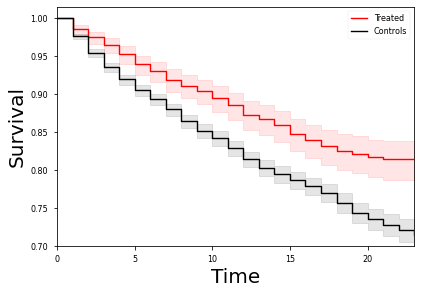

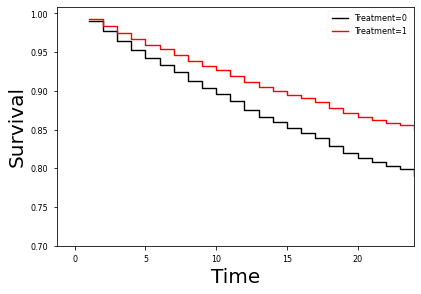

In [30]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
ylim = [0.7]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylim)

In [31]:
lrsumm

test_statistic             p   -log2(p)
Acute Care       28.606078  8.870331e-08  23.426437

In [32]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.435           0.181       -2.404    0.016
Total Cost                        0.060           0.011        5.618    0.000
Gender                           -0.033           0.055       -0.605    0.545
Tobacco Use                       0.057           0.077        0.751    0.453
Pressure                          0.458           0.232        1.972    0.049
Obesity                          -0.019           0.056       -0.339    0.734
Hypertension                      0.132           0.066        2.016    0.044
Hypothyroid                      -0.010           0.089       -0.114    0.909
Disease Count                     1.586           0.238        6.655    0.000
Acute Care 2 Months               1.543           0.096       16.032    0.000
Acute Care 6 Months               0.814           0.162        5.030    0.000
Inpatient Visits 6 Months        -0.489           0.143       -3.426    0.001
Emergency Vistits 6 Months       -0.479           0.156       -3.077    0.002
Line of Bussiness                -0.574           0.069       -8.288    0.000
Treatment                        -0.366           0.077       -4.787    0.000

### Acute Care  diff and diff calculation

In [33]:
%%time
from utils import findDate, filter_first_date
from data_functions import make_date_to_MYR

pmpm = pd.read_pickle("../Pre_Matching_DATA/"+'pmpm.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls_all = pd.read_pickle(p+'controls_all.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

CPU times: user 12.1 s, sys: 12.3 s, total: 24.4 s
Wall time: 24.4 s


In [34]:
%%time
tr = treated.copy().drop(columns = ['Treatment'], axis = 1)
cr = controls.copy().drop(columns = ['Treatment'], axis = 1)

treated2 = (filter_first_date(findDate(tr.copy(), pmpm.copy(), 5))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls2 = (filter_first_date(findDate(cr.copy(), controls_all.copy(), 5))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

try:
    controls2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    controls2 = controls2
try:
    treated2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    treated2 = treated2
treated2['Treatment'] = 1
controls2['Treatment'] = 0
data2 = [treated2,  controls2]
#for d in data2:
#    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

CPU times: user 27.2 s, sys: 2.24 s, total: 29.5 s
Wall time: 29.4 s


In [35]:
treated2.shape, controls2.shape

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


In [36]:
treated.PERS_ID.unique().shape, controls.PERS_ID.unique().shape

In [37]:
treated2.PERS_ID.unique().shape, controls2.PERS_ID.unique().shape

In [38]:
%%time
times = [0]
onset = 'ACUTE'


survTr = treated2.copy().groupby('PERS_ID').apply(survival_diabetes,  grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls2.copy().groupby('PERS_ID').apply(survival_diabetes, grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
# curves.append((survTr, survCo))

CPU times: user 12.2 s, sys: 73.2 ms, total: 12.3 s
Wall time: 12.3 s


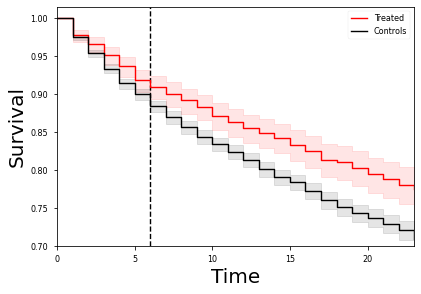

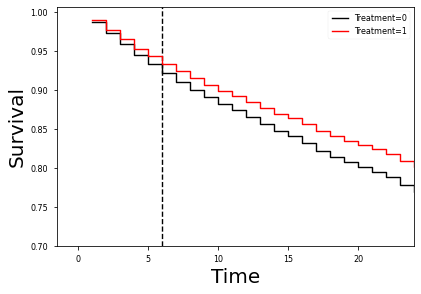

In [39]:
fittedDD, rmstAcuteDD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                      model = model, model_type = model_type,
                      model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                     log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care_dd'
ylim = [0.7]
lrsummDD, ax1, ax2, summDD = make_results(fittedDD, survTr, survCo, path_tabs = path_tabs, 
                                  path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                  model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                  filter_cols = filter_cols2, summary_names = summary_names,
                                 log_normalize = log_normalize, normalize = normalize,
                                 kaplan_plot_params=kaplan_plot_params,
                                  timeline = timeline,
                                  outcome_title = 0, ylim = ylim, ver_line = True, ver_line_val = 6)

In [40]:
lrsummDD

test_statistic         p   -log2(p)
Acute Care_dd       23.538363  0.000001  19.639402

In [41]:
summDD

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.082           0.156       -0.527    0.598
Total Cost                        0.063           0.009        6.721    0.000
Gender                           -0.044           0.049       -0.915    0.360
Tobacco Use                       0.012           0.071        0.168    0.867
Pressure                          0.325           0.223        1.460    0.144
Obesity                          -0.035           0.051       -0.682    0.495
Hypertension                      0.006           0.060        0.105    0.917
Hypothyroid                      -0.027           0.082       -0.327    0.744
Disease Count                     1.369           0.226        6.056    0.000
Acute Care 2 Months               1.330           0.090       14.733    0.000
Acute Care 6 Months               0.164           0.191        0.859    0.390
Inpatient Visits 6 Months        -0.178           0.156       -1.136    0.256
Emergency Vistits 6 Months        0.269           0.180        1.494    0.135
Line of Bussiness                -0.675           0.061      -11.151    0.000
Treatment                        -0.169           0.067       -2.526    0.012

### Load all Log Rank Sums in a matrix

In [42]:
from pathlib import Path
pp = Path(path_tabs)

df2 = None
for i, ff in enumerate(pp.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)

df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['LogRank Statistic', 'LogRank Test P-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care', 'Acute Care DD']
for month, i in zip([6,12,18,24], [0,1,2,3]):
    df2['RMST Difference After '+ str(month)+' Months'] = np.array([rmstD[i], rmstER[i], rmstIP[i], rmstAcute[i], rmstAcuteDD[i]])
df2.to_csv(path_tabs+'all_logrank.csv')

In [43]:
df2.round(2)

LogRank Statistic  LogRank Test P-value  \
Diabetes                       0.57                  0.45   
Emergency Visits              21.77                  0.00   
Inpatient Vistis              12.45                  0.00   
Acute Care                    28.61                  0.00   
Acute Care DD                 23.54                  0.00   

                  RMST Difference After 6 Months  \
Diabetes                                    0.01   
Emergency Visits                            0.10   
Inpatient Vistis                            0.04   
Acute Care                                  0.13   
Acute Care DD                               0.08   

                  RMST Difference After 12 Months  \
Diabetes                                     0.02   
Emergency Visits                             0.33   
Inpatient Vistis                             0.13   
Acute Care                                   0.41   
Acute Care DD                                0.28   

                  RMST Difference After 18 Months  \
Diabetes                                     0.02   
Emergency Visits                             0.63   
Inpatient Vistis                             0.27   
Acute Care                                   0.78   
Acute Care DD                                0.58   

                  RMST Difference After 24 Months  
Diabetes                                    -0.03  
Emergency Visits                             1.01  
Inpatient Vistis                             0.53  
Acute Care                                   1.29  
Acute Care DD                                0.94